# Advent of Code 2021 day 7 solution

## Intro 
In trying to figure out the intuition for this problem I ended up finding a brute force solution that worked well enough to get the answer. That kind of defeats the purpose of posting my solution code, since it works but doesn't really teach anything. Instead let's go through some iterations on ways to solve the problem in (hopefully) increasingly more efficient ways and working out how and why they work.

In [1]:
from typing import Callable
from collections import defaultdict
import pandas as pd


In [2]:
with open("input.txt", "r") as f:
    crabs_list = [int(x) for x in f.readline().strip().split(",")]

Below is a sample of the puzzle inputs, it's just a list of integers representing points where we have crabs on the integer number line.

In [3]:
crabs_list[:5]

[1101, 1, 29, 67, 1102]

## Puzzle Part 1

We're trying to find a point on the number line that minimizes the fuel expended by all the crabs to travel to it. So first we have to define a function that computes the amount of fuel a crab needs to use to get to an arbitrary point:

Bit of a spoiler for part 2 - the fuel formula changes so I will label this as the calculation for part 1

In [4]:
def p1_fuel_calc(crab: int, point: int) -> int:
    """Compute fuel required for a crab to travel to a point."""
    return abs(crab - point)

The next thing we need is something to calculate the total fuel expenditure used by all the crabs to travel to a given point:

I can think of two ways to do this. The first is just to sum up the result of calling the fuel calculation on every crab in the crab list. The slightly fancier way to do it would be to first count up the number of crabs at every position and then return the sum of multiplying the number of crabs at each point by their fuel calculation. I'm pretty sure the simple way is faster but I'm not sure. I'm sure it depends to some extent on how many repetitions there are, and how hard the fuel calculation is, but let's try both and see what works better.

In [5]:
def tot_fuels_sum_all(point: int, fuel_func: Callable = p1_fuel_calc) -> int:
    return sum(fuel_func(crab, point) for crab in crabs_list)

def tot_fuels_count_first(point: int, fuel_func: Callable = p1_fuel_calc) -> int:
    crab_counter = defaultdict(int)
    for crab in crabs_list:
        crab_counter[crab] += 1
    return sum(crabcount * fuel_func(crab, point) for crab, crabcount in crab_counter.items())

def tot_fuels_alt_count_first(point: int, fuel_func: Callable = p1_fuel_calc) -> int:
    crab_counter = dict()
    for crab in set(crabs_list):
        crab_counter[crab] = crabs_list.count(crab)
    return sum(crabcount * fuel_func(crab, point) for crab, crabcount in crab_counter.items())

In [6]:
%timeit tot_fuels_sum_all(7)

246 µs ± 54.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%timeit tot_fuels_count_first(7)

346 µs ± 6.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%timeit tot_fuels_alt_count_first(7)

12.4 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In this case it looks like the cost of doing the counting really outweighs the cost of calculating fuel multiple times. Especially that second counting method, that's way slower. I'll come back to this in part 2 where the fuel formula is a little more complicated.

In [9]:
# Give the best solution a shorter name
tot_fuels = tot_fuels_sum_all

Now that we have a way of evaluating fuel consumption for an arbitrary point we need to find the point that minimizes that fuel consumption. There are lots of clever ways to do this, but let's try the simplest one first. We'll just check every point, calculate its fuel, and then find the minimum.

In [10]:
def min_fuel_brute_force(fuel_func: Callable = p1_fuel_calc) -> int:
    small_crab = min(crabs_list)
    big_crab = max(crabs_list)
    fuel_amounts = [tot_fuels(i, fuel_func) for i in range(small_crab, big_crab + 1)]
    return min(fuel_amounts)

In [11]:
min_fuel_brute_force()

359648

That gets the right answer, but let's see how long it takes to run:

In [12]:
%timeit min_fuel_brute_force()

373 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Not terrible, but I'm sure we can do better. Before coming up with better solutions let's take a quick look at what all these different fuel amounts look like:

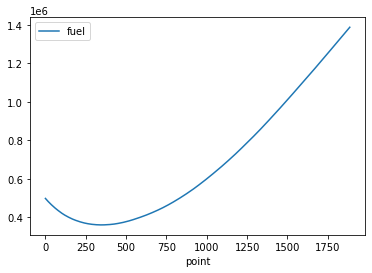

In [13]:
df = pd.DataFrame()
for i in range(max(crabs_list)):
    df.loc[i, "point"] = i
    df.loc[i, "fuel"] = tot_fuels(i)
df.plot(x="point", y="fuel");

This is a nice smooth looking function plotting fuel used against the destination point. When I see a function like this I start thinking about finding a place where the derivative of the function is == 0, but let's not get ahead of ourselves. There's one more iteration of kind of simple but still potentially faster solutions I want to try:

In [14]:
def min_fuel_descent(fuel_func: Callable = tot_fuels, start_func: Callable = min) -> int:
    point_guess = start_func(crabs_list)
    # Sketchy but I'm going to just do my return in the loop
    while True:
        point_fuel = fuel_func(point_guess)
        point_plus_fuel = fuel_func(point_guess + 1)
        point_minus_fuel = fuel_func(point_guess - 1)
        if point_plus_fuel < point_fuel:
            point_guess += 1
        elif point_minus_fuel < point_fuel:
            point_guess -= 1
        else:
            return point_fuel

For reference here's the old implementation speed for checking every single point:

In [15]:
%timeit min_fuel_brute_force()

378 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


And here's the new implementation, starting at the minimum and the maximum starting points

In [16]:
%timeit min_fuel_descent(start_func=min)

206 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit min_fuel_descent(start_func=max)

943 ms ± 9.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A bit of a speed up if we start relatively near the minimum point, but if we start super far away it's actually slower because for each step it has to compute 3 fuel amounts. We could improve this by doing some estimate of the slope of the function at a given point and modifying out step size based on the slope, but this is getting a little tortured so let's skip to the analytic solution.

It turns out that all you have to do to minimize the fuel given this formula is to find the median value of the list. [This stackexchange](https://math.stackexchange.com/questions/113270/the-median-minimizes-the-sum-of-absolute-deviations-the-ell-1-norm/113336#113336) thread goes into some details, which I'll reproduce a bit of below after we show that it works.

In [18]:
min_fuel_brute_force()

359648

In [19]:
from statistics import median
def min_fuel_p1_smart():
    med_crab = int(median(crabs_list))
    return tot_fuels(med_crab)

In [20]:
min_fuel_p1_smart()

359648

In [21]:
%timeit min_fuel_p1_smart()

280 µs ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now this runs in almost the same time as doing a single fuel calculation for a point, plus some minimal overhead for finding the median. 
Significantly faster. But why does this work?

There's a calculus based answer in the previously linked thread but it involves taking a derivative of a function that includes absolute values, and I don't feel like doing that. The intuitive answer in the top response makes a lot of sense to me. The shortened version is to imagine your point as being anywhere along the line of all the crabs. If you slightly from that point to the right you will move some amount away from all the crabs that were to the left of you, and the same amount closer to all the crabs that are to the right of you. If there are more crabs to the left of you than the right the total distance increase from them will outweigh the total distance decrease from all the crabs to the right and your total fuel cost will increase. Based on this, as long as you can move towards the direction that has more crabs, you'll always be decreasing your fuel consumption. Which means the minimum will be where there are exactly the same number of crabs to your right and left, which is the definition of the median.

## Puzzle part 2

Part 2 modifies the challenge by changing the fuel calculation. In part one it was just the absolute distance between the crab and the point. In part 2 each additional step for the crab costs 1 more fuel than the last, so for a distance of $n$ the total fuel is $1 + 2 + ... + n$ or $\sum_{i=1}^{n} i$

The first thing we have to do is define a new fuel calculation method to account for this new formula. We could do it using just the formula that's defined above, but there's a faster way to do it, let's see how much better that works.

In [22]:
def p2_fuel_calc_slow(crab: int, point: int) -> int:
    """Compute fuel required for a crab to travel to a point."""
    distance = abs(crab - point)
    return sum(i for i in range(distance + 1))

The much faster way to do this is called [Gaussian summation](https://letstalkscience.ca/educational-resources/backgrounders/gauss-summation)
Let's implement that and compare:

In [23]:
def p2_fuel_calc(crab: int, point: int) -> int:
    """Compute fuel required for a crab to travel to a point."""
    distance = abs(crab - point)
    return int(distance * (distance + 1) / 2)

In [24]:
%%timeit
point = 0
for crab in crabs_list:
    _ = p2_fuel_calc_slow(crab, point)

28 ms ± 587 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit
point = 0
for crab in crabs_list:
    _ = p2_fuel_calc(crab, point)

364 µs ± 7.34 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


That's a pretty significant speedup!

Now to actually solve part 2. Now that our fuel calculation is much slower (at least with the slow calculation) we can also check if counting crabs first helps things:

In [26]:
%timeit tot_fuels_sum_all(7, fuel_func=p2_fuel_calc_slow)

27.8 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit tot_fuels_count_first(7, fuel_func=p2_fuel_calc_slow)

23 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit tot_fuels_alt_count_first(7, fuel_func=p2_fuel_calc_slow)

35.1 ms ± 771 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It looks like with the slower fuel calculation it's about a draw counting the crabs first with just evaluating it for each of them. So there's really no reason to do the counting, it just makes things more complicated for no real speedup.

Let's see how long it would take to solve part 2 using the brute force (check every point along the crab line as a candidate) and slower fuel calculation method:

In [29]:
%timeit min_fuel_brute_force(fuel_func=p2_fuel_calc_slow)

1min 23s ± 7.85 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Well that's gross. We probably shouldn't use that solution.

How does that compare to using the faster calculation?

In [30]:
%timeit min_fuel_brute_force(fuel_func=p2_fuel_calc)

848 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's much better. Given that we've already found a solution that takes less than a second to run, there's not really any good reason to take this further, but just for fun let's give it a try.

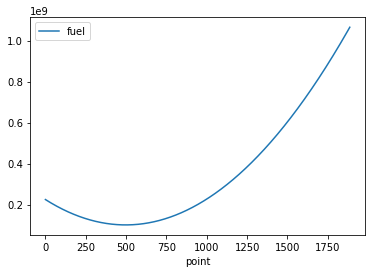

In [31]:
df = pd.DataFrame()
for i in range(max(crabs_list)):
    df.loc[i, "point"] = i
    df.loc[i, "fuel"] = tot_fuels(i, fuel_func=p2_fuel_calc)
df.plot(x="point", y="fuel");

Again we can see that this looks like a differentiable function, so if we could find the derivative of the fuel function, the point where that derivative is == 0 would be the minimum fuel. Someone much smarter than me wrote up a derivation that shows the minimum point will be += 0.5 of the mean value of the crab positions. You can find the whole write up [here](https://www.reddit.com/r/adventofcode/comments/rawxad/2021_day_7_part_2_i_wrote_a_paper_on_todays/)

In [32]:
from statistics import mean
def min_fuel_p2_smart():
    mean_crab = int(round(mean(crabs_list)))
    mean_plus = mean_crab + 1
    mean_min = mean_crab - 1
    check_points = [mean_crab, mean_plus, mean_min]
    return min(tot_fuels(point, fuel_func=p2_fuel_calc) for point in check_points)


In [33]:
%timeit min_fuel_p2_smart()

1.9 ms ± 52.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Hundreds of times faster! Amazing! Totally worth all this time to work out.

Oh, we should make sure it actually works:

In [34]:
min_fuel_brute_force(fuel_func=p2_fuel_calc)

100727924

In [35]:
int(df["fuel"].min())

100727924

In [36]:
min_fuel_p2_smart()

100727924

Oh good, they all agree. There we go, here's how to spend a bunch of extra time to get orders of magnitude faster (but also imperceptible to people) speedups in the implementation of day 7 of the 2021 advent of code challenge.